In [1]:
import sys
import os

%matplotlib inline


In [2]:
import os
import matplotlib.pyplot as plt

from pathlib import Path
import regex
import glob
import os
import itertools
from collections import namedtuple


In [3]:

DIR = Path("/mnt/c/Users/Lenovo/Documents/Projects/ProteinCurvature/robust-surface-curvature/")
os.chdir("./..")

In [4]:
DIR

PosixPath('/mnt/c/Users/Lenovo/Documents/Projects/ProteinCurvature/robust-surface-curvature')

In [5]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
from math import sqrt
from sys import stderr
from numpy import linalg
import networkx as nx
from scipy.spatial import Delaunay, ConvexHull
import re
import itertools
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull
#key functions
from utils.Hypersphere import fit_hypersphere
from utils.read_msms import read_msms
from Bio.PDB.ResidueDepth import ResidueDepth
from Bio.PDB.PDBParser import PDBParser

In [6]:
def unit_vector(x):
    return x/np.linalg.norm(x)

def unit_normal(v1, v2, v3):
    v1, v2, v3 = np.array(v1), np.array(v2), np.array(v3)
    v31 = v3 - v1
    v21 = v2 - v1
    cross = np.cross(v31/np.linalg.norm(v31), v21/np.linalg.norm(v21))
    return cross/ np.linalg.norm(cross)

In [7]:

import collections
import regex
import pickle
import re

import numpy as np
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import cophenet
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
from matplotlib import rcParams
import os
import copy

from scipy.cluster.hierarchy import fcluster
from scipy.cluster.vq import kmeans, vq
import scipy.cluster.hierarchy as sch
from collections import OrderedDict
import subprocess
import unittest
import glob
import matplotlib.pyplot as plt


In [8]:
SMALL_SIZE = 10
MEDIUM_SIZE = 13
BIGGER_SIZE = 13

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes

plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
rcParams.update({'figure.autolayout': True})

In [11]:
path = Path(r"/mnt/c/Users/Lenovo/Documents/Projects/ProteinCurvature/robust-surface-curvature/data")
sub_path = Path(r"/mnt/c/Users/Lenovo/Documents/Projects/robust-surface-curvature/data/Protein-inhibitor")
OUTPUT = "output_protein-ligand"
try:
    os.mkdir(os.path.expanduser(path/OUTPUT))
except FileExistsError:
    print("it exists")
# path=r"/home/abhijit/Downloads/out_cabc.dms"
for files in glob.glob(sub_path.as_posix()+"/*.dms"):
    filename = files
    structure_id = regex.search(
        r"(?:.+[/\\])(.+)(?:\.dms)", filename).group(1)
    s1 = structure_id

    import re
    import numpy as np
    with open(filename, 'r') as f:
        k = f.read()
    pattern = re.compile(r"(.{20,})(?:\bA\b)", flags=re.M | re.I)
    pattern2 = re.compile(r"(.{20,})(?:\bS\w+\b)(.+)", flags=re.M)
    l1 = pattern.findall(k)
    l2 = pattern2.findall(k)
    iterables1 = {}
    iterables_orig = {}
    iterables_normal_area = {}

    for x, y in l2:
        search = regex.search(
            r"(\w{,3})\s*(\w+)(?:\*?)\s*(\w+)(?:\*|'?)\s*(-?\d+\.\d+)\s*(-?\d+\.\d+)\s*(-?\d+\.\d+)", x)
        iterables1[tuple(map(float, [search.group(4), search.group(5), search.group(6)]))] = [
            x, list(map(float, y.split()[:]))]

    for x in l1:
        search = regex.search(
            r"(\w{,3})\s*(\w+)(?:\*?)\s*(\w+)(?:\*|'?)\s*(-?\d+\.\d+)\s*(-?\d+\.\d+)\s*(-?\d+\.\d+)", x)
        iterables_orig[tuple(
            map(float, [search.group(4), search.group(5), search.group(6)]))] = [x]
    pattern_new = regex.compile(
        r"(\w{3})\s*(\w+)\s*(\w+)\s*(-?\d+\.\d+)\s*(-?\d+\.\d+)\s*(-?\d+\.\d+)")
    data = np.array([x for x in iterables1.keys()])
    data = np.array(data, 'float64')
    Z = linkage(data, 'complete')  # ward --> complete
    max_d = 5  # patch
    clusters = fcluster(Z, max_d, criterion='distance')
    curvature = collections.defaultdict(list)
    centroid = np.median(data, axis=0)
    with open(os.path.expanduser(path.as_posix()+'/%s/%s_%s.pdb' % (OUTPUT, s1, 'X')), 'w') as f:
        dist = []
        j = 0
        for i in range(1, max(clusters)+1):
            curv1_p = []
            curv2_p = []
            curv_m = fit_hypersphere(data[clusters == i])
            ci = curv_m[1]
            count = []
            d_centroid = np.linalg.norm(centroid-ci)

            for x in data[clusters == i]:

                d = np.linalg.norm(ci-x)
                d_c = np.linalg.norm(centroid-x)
                if d_c > d_centroid:
                    # if d>curv_m[0]:
                    count.append(1)
                    curv1_p.append(x)
                else:
                    count.append(-1)
                    curv2_p.append(x)

            A = (len(curv1_p)/len(data[clusters == i]))
            B = (len(curv2_p)/len(data[clusters == i]))
            for x in curv1_p:
                curvature[tuple(x)] = A*100/curv_m[0]**1
            for x in curv2_p:
                curvature[tuple(x)] = B*-100/curv_m[0]**1  # put - sign

    j = 0
    with open(os.path.expanduser(path.as_posix()+'/%s/%s_%s.pdb' % (OUTPUT, s1, 'X')), 'w') as f:
        for _, x in enumerate(curvature.keys()):

            loc1 = iterables1[tuple(x)]
            loc = loc1[0].split()
            print("{:6s}{:5d} {:^4s}{:1s}{:3s} {:1s}{:4d}{:1s}   {:8.3f}{:8.3f}{:8.3f}{:6.2f}{:6.2f}          {:>2s}{:2s}".format("ATOM", j, "A", " ", loc[0], "X",
                                                                                                                                  int(loc[1].rstrip(regex.search(r'(\d+)(.*)', loc[1]).group(2))), '', x[0], x[1], x[2], loc1[1][0],  curvature[tuple(x)], '', loc[2]), file=f)

            j += 1

    dist = [curvature[x] for x in curvature]
    dist = np.array(dist)
    dots = len(dist)
    plt.figure()
    plt.xlabel(
        "Curvature($\kappa$)\n$\longleftarrow$ concave | convex $\longrightarrow$")
    plt.ylabel("number of surface points")
    plt.title('%s %s:Number of surface points: %d\nScaling factor: 100*$\kappa$' %
              (s1.upper(), "", len(dist)))
    plt.hist(dist, bins=15, color='gray', alpha=0.8)
    plt.savefig(os.path.expanduser(path.as_posix()+'/%s/%s_%s_%s hist.jpeg' %
                                   (OUTPUT, dots, s1, 'X')), format='jpeg', dpi=300)
    plt.close()

it exists


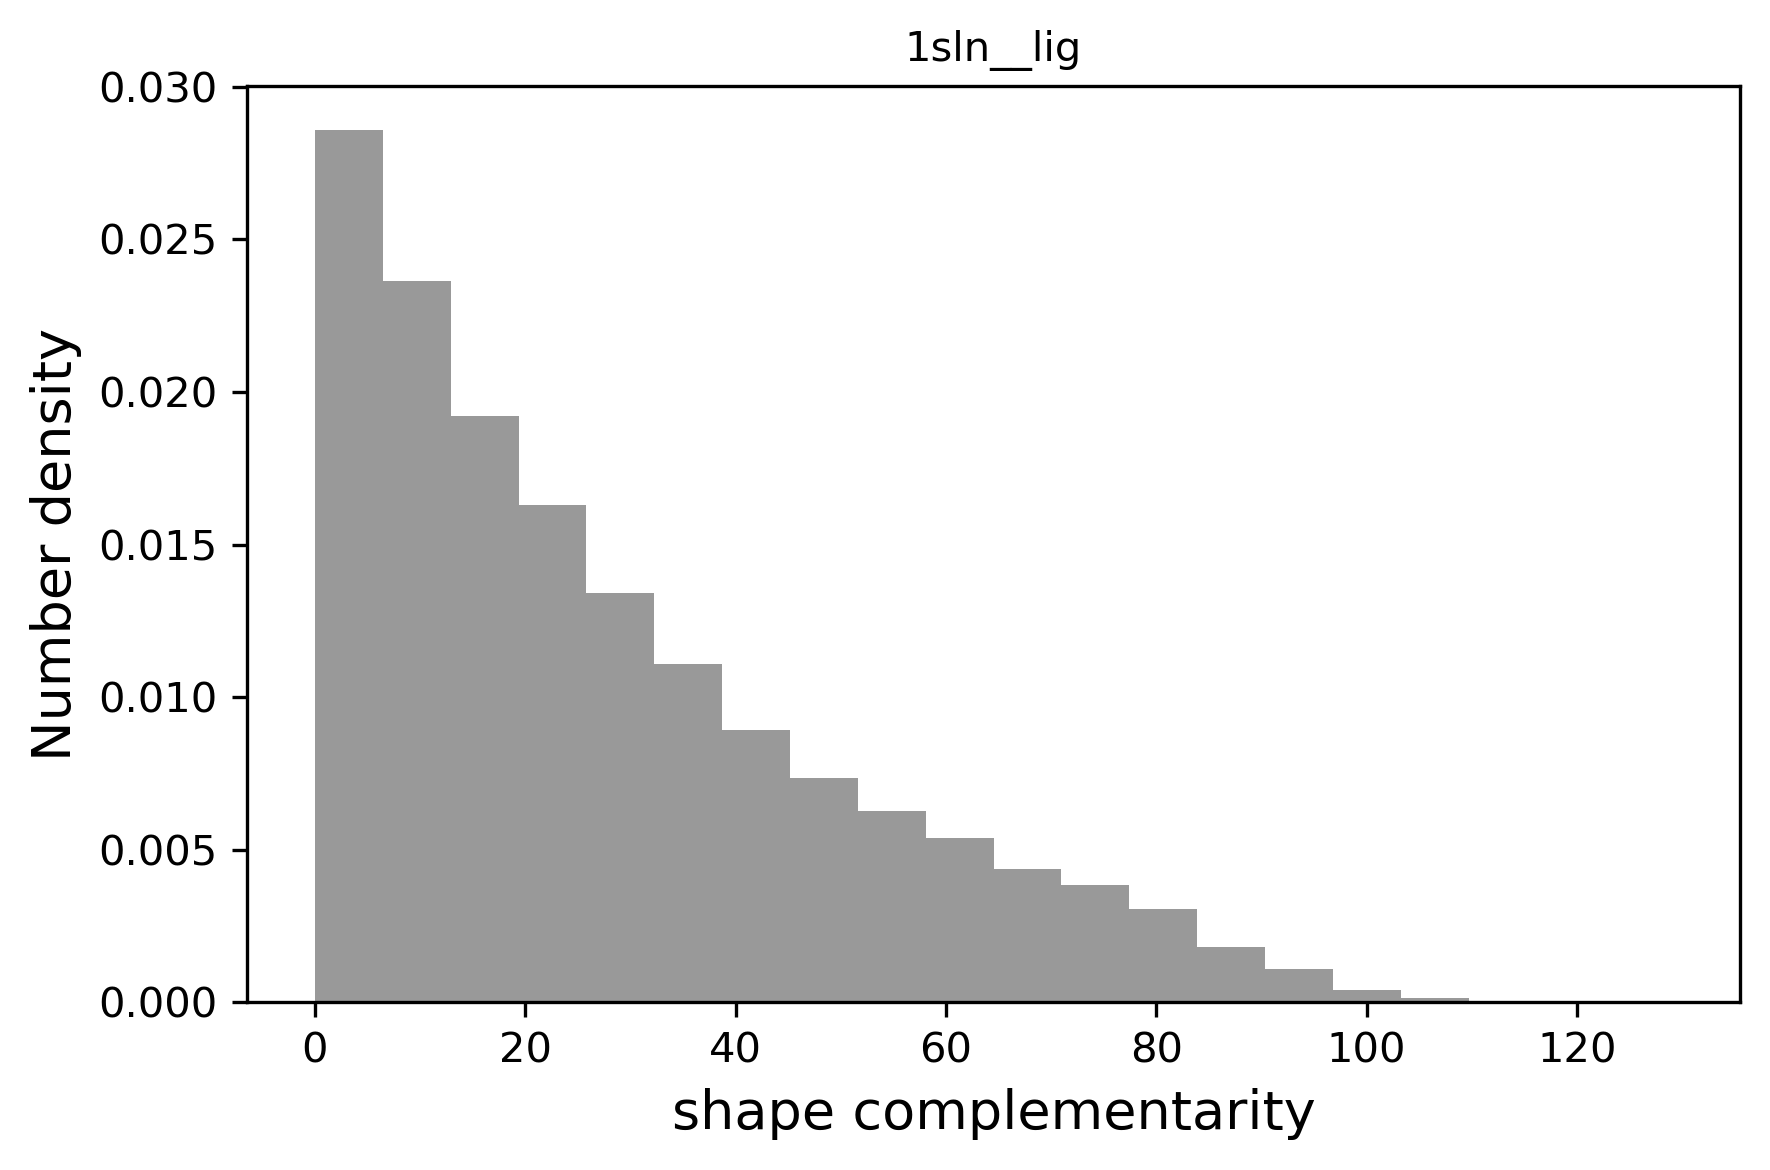

In [15]:
from matplotlib import rcParams
"""
Protein - Ligand

"""
import os
import glob
import regex
import collections
import re
import copy
import itertools
import matplotlib.pyplot as plt
from scipy.spatial import distance

SMALL_SIZE = 10
MEDIUM_SIZE = 13
BIGGER_SIZE = 13

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes

plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
rcParams.update({'figure.autolayout': True})

sub_path = Path(r"/mnt/c/Users/Lenovo/Documents/Projects/ProteinCurvature/robust-surface-curvature/data/Protein-inhibitor/")

pdb_id = collections.defaultdict(list)
dms_id = collections.defaultdict(list)
dms_path = os.path.expanduser(sub_path.as_posix()+"/*.dms")

for files in glob.glob(dms_path):
    filename = files
    structure_id = regex.search(
        r"(?:.+[/\\])(.+)(?:\.dms)", filename, flags=regex.I).group(1)
    s1 = structure_id
    dms_id[structure_id].append(filename)

dms_normal = {}
for name_dms in dms_id:
    with open(dms_id[name_dms][0], 'r') as f:
        k = f.read()
    pattern = re.compile(r"(.{20,})(?:\bA\b)", flags=re.M | re.I)
    pattern2 = re.compile(r"(.{20,})(?:\bS\w+\b)(.+)", flags=re.M)
    l1 = pattern.findall(k)
    l2 = pattern2.findall(k)
    iterables1 = {}
    iterables_orig = {}
    iterables_normal_area = {}
    for x, y in l2:
        search = regex.search(
            r"(\w{,3})\s*(\w+)(?:\*?)\s*(\w+)(?:\*|'?)\s*(-?\d+\.\d+)\s*(-?\d+\.\d+)\s*(-?\d+\.\d+)", x)
        iterables1[tuple(map(float, [search.group(4), search.group(
            5), search.group(6)]))] = list(map(float, y.split()[1:]))
    dms_normal[name_dms] = copy.deepcopy(iterables1)

for files in glob.glob((path/OUTPUT).as_posix()+"/*.pdb"):
    filename = files
    structure_id = regex.search(
        r"(?:.+/)(.{4})(?:.*_X\.pdb)", filename).group(1)
    pdb_id[structure_id].append(filename)


for name_pdb in pdb_id:
    for i in itertools.combinations(pdb_id[name_pdb], 2):
        with open(i[0], 'r') as f:
            k = f.readlines()
        iterables = {}
        arr1 = []
        arr1_norm = []
        if(regex.search(r"_lig_X", i[0])):
            suffix = "_lig"
        else:
            suffix = ""
        for x in k:
            iterables.setdefault(x[60:66].replace(" ", ""), []).append(list
                                                                       (map(float, [x[30:38].replace(" ", ""),
                                                                                    x[38:46].replace(
                                                                                        " ", ""),
                                                                                    x[46:54].replace(" ", "")])))
            arr1.append(list(map(float, [x[30:38].replace(" ", ""),
                                         x[38:46].replace(" ", ""),
                                         x[46:54].replace(" ", ""), x[60:66].replace(" ", "")])))
            arr1_norm.append(dms_normal[name_pdb+suffix][tuple(map(float, [x[30:38].replace(" ", ""),
                                                                           x[38:46].replace(
                                                                               " ", ""),
                                                                           x[46:54].replace(" ", "")]))])
        with open(i[1], 'r') as f:
            k1 = f.readlines()

        iterables1 = {}
        arr2 = []
        arr2_norm = []
        if(regex.search(r"_lig_X", i[1])):
            suffix = "_lig"
        else:
            suffix = ""
        for x in k1:
            iterables1.setdefault(x[60:66].replace(" ", ""), []).append(list
                                                                        (map(float, [x[30:38].replace(" ", ""),
                                                                                     x[38:46].replace(
                                                                                         " ", ""),
                                                                                     x[46:54].replace(" ", "")])))
            arr2.append(list(map(float, [x[30:38].replace(" ", ""),
                                         x[38:46].replace(" ", ""),
                                         x[46:54].replace(" ", ""), x[60:66].replace(" ", "")])))
            arr2_norm.append(dms_normal[name_pdb+suffix][tuple(map(float, [x[30:38].replace(" ", ""),
                                                                           x[38:46].replace(
                                                                               " ", ""),
                                                                           x[46:54].replace(" ", "")]))])
        arr1 = np.array(arr1)
        arr2 = np.array(arr2)
        arr1_norm = np.array(arr1_norm)
        arr2_norm = np.array(arr2_norm)
        normal_product = np.dot(arr2_norm, arr1_norm.T)

        arr_dist = distance.cdist(
            arr2[:, (0, 1, 2)], arr1[:, (0, 1, 2)], 'euclidean')

        new_dist = np.exp(-1*(arr_dist-np.mean(arr_dist, axis=0))
                          ** 2/(2*np.var(arr_dist, axis=0)))

        new_curv = distance.cdist(arr2[:, (3,)], -1*arr1[:, (3,)], 'cityblock')
        dat_new = (np.multiply(new_curv, new_dist)).flatten()
        plt.figure(dpi=300)

        plt.xlabel("shape complementarity")
        plt.ylabel("Number density")
        plt.hist(dat_new, bins=20, density=True, color='gray', alpha=0.8)
        plt.title("%s_%s" % (name_pdb, "_lig"))
        plt.show()
        plt.savefig(path.as_posix()+"/%s_%s_plot.jpeg" %
                    (name_pdb, "_lig"), format='jpeg', dpi=300)
        plt.close()

In [14]:
%%bash
cd data
ls

1sln__lig_plot.jpeg
2hnp.face
2hnp.vert
output_protein-ligand
Protein-inhibitor
